### ASTR-324, Spring 2017, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s17/astr-324-s17/notebooks/Week-4-Thu.ipynb


# Week 5, Tuesday: Parameter estimation and model selection with MCMC. I



##### Resources for this notebook include:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.  
- [Gordon Richard's notebooks](https://github.com/gtrichards/PHYS_T480)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:
- [Thomas Wiecki: ``MCMC sampling for dummies by Thomas Wiecki"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
  
##### For those who want to dive deep:
- [Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

##### Topics for this week: 
- Recap of the last week and a discussion of BIC derivation 
- Introduction to Markov Chain Monte Carlo (MCMC) methods
- MCMC applied to multi-dimensional parameter estimation
- MCMC applied to Bayesian model selection problems

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev

## Bayesian Statistical Inference

In Bayesian inference, we evaluate the **posterior probability** by using
** data likelihood** and **prior** information: 
 
$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

The prior can be expanded as 
$$p(M,\theta\,|\,I) = p(\theta\,|\,M,I)\,p(M\,|\,I).$$
 
It is often the case that $p(D\,|\,I)$ is not evaluated explictly since the posterior probability 
can be (re)normalized. 

**The Bayesian Statistical Inference process** is then
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates (credible region)
 
 
### Bayesian Model Comparison

To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as
$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

The posterior probability that the model $M$ is correct given data $D$ is
$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$
and the odds ratio can ignore $p(D|I)$ since it will be the same for both models. 

We get 
$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$
where $B_{21}$ is called the Bayes factor. 

The Bayes factor compares how well the models fit the data: it is a ratio of data likelihoods averaged over 
all allowed values of the model parameters and computed as
$$B_{21} = \frac{\int p(D\,|\,M_2, \theta, I) \, p(\theta\,|\,M_2, I) \, d\theta}{\int p(D\,|\,M_1, \theta, I) \, p(\theta\,|\,M_1, I) \, d\theta}. $$
 
In other words, the Bayes factor is the ratio of **the global likelihoods for models $M_1$ and $M_2$**, 
where the global likelihood, or evidence, is a weighted average of the likelihood function, with the 
prior for model parameters acting as the weighting function.

N.B. To get the best-fit model parameters, we take a derivative of the product of the likelihood function
and priors (and equate it to 0), while to get the global likelihood we integrate it. 
 
**How do we interpret the values of the odds ratio, $O_{21}$, in practice?**

Jeffreys proposed a five-step scale for 
interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ 
is ten times more probable than $M_1$; analogously $O_{21} < 0.1$ is “strong” evidence in favor of $M_1$), 
and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). 
When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

  
### Approximate Bayesian Model Comparison

The data likelihood, required to compute the models odds ratio, and the commonly 
used $\chi^2$ goodness-of-fit parameter are related. By introducting a few 
assumptions and approximations, the computations of the odds ratio can be
greatly simplified and expressed as the sum of $\chi^2$ and a term that penalizes
models for their parameters (when models achieve similar values of $\chi^2$,
the one with the smallest number of free parameters wins). 
 
We consider a one dimensional case with unknown parameter $\mu$ and
start with an approximate computation of the evidence $E(M)$,
$$ E(M) = \int p(\{x_i\}, \,|\,M, \mu, I) \, p(\mu \,|\,M, I) \, d \mu .$$

Our first assumption is that the prior is uniform 
$$  p(\mu\,|\, M, I) = \frac{1}{\Delta} \,\,\,\,\,\, {\rm for} \,\,\, -\frac{\Delta}{2} < \mu < \frac{\Delta}{2}$$
and 0 otherwise. 

The second assumption is that the data likelihood can
be approximated as a Gaussian around its maximum at $\mu=\mu_0$
$$ p(\{x_i\} \,|\,M, \mu, I) \approx L(\mu_0) \, \exp \left( - \frac{(\mu - \mu_0)^2}{2 \sigma_\mu^2} \right). $$

These assumptions lead to 
$$ E(M) \approx \frac{L(\mu_0)}{\Delta} \, \int_{-\Delta/2}^{\Delta/2} \exp \left( - \frac{(\mu - \mu_0)^2}{2 \sigma_\mu^2}\right) d\mu, $$
and with an additional assumption $\sigma_\mu \ll \Delta$ (data overcomes
the prior), we get
$$ E(M) \approx \frac{\sigma_\mu}{\Delta} \, L(\mu_0) \, \sqrt{2\pi}. $$

Note that $E(M) \ll L(\mu_0)$, because $\sigma_\mu \ll \Delta$. In multi-dimensional
case, each model parameter constrained by the model carries a similar 
multiplicative penalty, proportional to $\sigma_\mu/\Delta$, when computing the 
Bayes factor. If a parameter, or a degenerate parameter combination, is unconstrained 
by the data (i.e., $\sigma_\mu \approx \Delta$), there is no penalty.  
The odds ratio can justify an additional model parameter **only if this penalty is offset** by either 
an increase of the maximum value of the data likelihood, $L(\mu_0$), or by the ratio 
of prior model probabilities, $p(M_2|I)/p(M_1|I)$. If both of these quantities are 
similar for the two models, the one with fewer parameters typically wins.

If a model is well constrained by the data, for each of $k$ constrained
parameters, $\sigma_\mu \propto 1/\sqrt{N}$, where $N$ is the number of data 
points. Therefore,
$$ E(M) \propto L(\mu_0) \, \left(\sqrt{N}\right)^k. $$
 
In order to establish connection with $\chi^2$ via $L(\mu_0) =
\exp\left(-\frac{\chi^2}{2}\right)$, we define for a model the **Bayesian information 
criterion (BIC)** as $BIC \equiv -2\ln{E(M)}$, and finally obtain  
$${\rm BIC} = -2 \ln [L_0(M)] + k \ln N.$$ 
The 1st term on the RHS is equal to model's $\chi^2$ (under the assumption 
of normality; note that this is *not* $\chi^2$ per degree of freedom!) and 
the 2nd term on the RHS penalizes complex models relative to simple ones.

In summary, when multiple models are considered, their BIC values, computed as
$${\rm BIC} = \chi^2 + k \ln N,$$ 
where $N$ is the number of data points and $k$ is the number of constrained
model parameters, are compared and the model with the smallest BIC value wins.   
 
**N.B.** BIC is an approximation and might not be valid if the underlying 
assumptions (data ovecoming prior and Gaussian likelihood) are not met! In general, it is better to compute the odds ratio when computationally feasible.

   
 

## Coin Flip as an Example of Bayesian Model Comparison

Let's look at an example we already discussed: the coin flip. Let's assume we have
N draws and k are success (say, heads). 

We will compare two hypotheses; 

**M1**: the coin has a known heads probability $b_\ast$ (say, a fair coin with $b_\ast=0.5$), and 

**M2**: the heads probability $b$ is unknown, with a uniform prior in the range 0–1. 
Note that the prior for model M1 is a delta function, $\delta(b-b_\ast)$. 

Given a model parametrized by the probability of success $b$, the likelihood that the data set 
contains k outcomes equal to 1 is given by 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

For model M2 the prior for $b$ is flat in the range 0-1 and the product of the 
data likelihood and prior is same as above. However, for model M1 the prior is a 
delta function $\delta(b-b_\ast)$ and we get for the product of the 
data likelihood and prior  
$$    p(k\,|\,b_\ast, N, M1)\,p(b|M1, I) = \frac{N!}{k! \, (N-k)!} \, b_\ast^k \, (1-b_\ast)^{N-k}. $$

Consequently, the odds ratio is given by 
$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$
as illustrated in the following figure. 

 
![OddsRatio](figures/odds.tiff)

This figure (from the textbook) illustrates the behavior of $O_{21}$ as a function of $k$
for two different values of N and for two different values of $b_\ast$: $b_\ast = 0.5$ 
(M1: the coin is fair) and $b_\ast = 0.1$. As the figure shows, the ability to distinguish 
the two hypothesis **improves** with the sample size. For example, when $b_\ast= 0.5$ and 
k/N = 0.1, the odds ratio in favor of M2 increases from about 9 for N = 10 to about 
263 for N = 20. When k = $b_\ast N$, the odds ratio is 0.37 for N = 10 and 0.27 for N = 20. 
In other words, **the simpler model is favored by the data**, and the support strengthens 
with the sample size. 

It is easy to show by integration of the above equation for $O_{21}$ that 
$O_{21}= \sqrt{\pi/(2N)}$ when k = $b_\ast N$ and $b_\ast = 0.5$. For example, to build strong 
evidence that a coin is fair, $O_{21} < 0.1$, it takes as many as N $>$ 157 tosses. With 
N = 10,000, the heads probability of a fair coin is measured with a precision of 1% and
the corresponding odds ratio is $O_{21} \approx 1/80$, approaching Jeffreys’ decisive 
evidence level. 
 
In **frequentist approach**, we would ask whether we can reject the null hypothesis that 
our coin is fair. We would ask whether a given $k$ is a very unusual outcome (at some 
significance level $\alpha$, say $\alpha=0.05$, which corresponds to about "2$\sigma$"
deviation) for a fair coin with $b_\ast = 0.5$ and with
a given N. In the **Bayesian approach**, we offer an alternative hypothesis that the coin 
has an unknown heads probability. While this probability can be estimated from provided 
data ($b_0$), **we consider all the possible values** of $b_0$ when comparing the two proposed 
hypotheses. 

As a numerical example, let's consider N=20 and k=16. Using the results discussed earlier, 
we find that the scatter around the expected value $k_0 = b_\ast N$ = 10 is $\sigma_k = 2.24$. 
Therefore, k = 16 is about 2.7$\sigma_k$ away from $k_0$, and at the adopted significance 
level $\alpha=0.05$ we **reject the null hypothesis** (this rejection means that it is unlikely that k = 16 would have arisen by chance). Of course, k = 16 does **not** imply 
that it is impossible that the coin is fair (infrequent events happen, too!).

As shown in the above figure, the chosen parameters (N=20 and k=16) correspond to the 
Bayesian **odds ratio** of about 10 in favor of hypothesis M2.  


### Approximate Bayesian Model Comparison

Let's now use BIC to address the same problem and illustrate how model M2 gets 
penalized for its free parameter. Essentially, we want an approximation for the
integral expression for $O_{21}$
$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$
 
We can approximate 
$$ E(M2) \approx \sqrt{2\pi} \, L(b_0) \, \sigma_b, $$
where $b_0 = k/N$ and for largish N we have $\sigma_b \approx \sqrt{b_0(1-b_0)/N}$. 

For M1, we have exact result because the prior is $\delta$ function
$$ E(M1) = \frac{N!}{k! \,(N=k)!} b_\ast^k (1-b_\ast)^{N-k}.$$

And the odds ratio becomes
$$ O_{21} \approx \sqrt{2\pi} \, \sigma_b \,
\left(\frac{b_0}{b_\ast}\right)^k \left(\frac{1-b_0}{1-b_\ast}\right)^{N-k} =
\sqrt{2\pi}\, \sqrt{\frac{b_0(1-b_0)}{N}} \, \left(\frac{b_0}{b_\ast}\right)^k \left(\frac{1-b_0}{1-b_\ast}\right)^{N-k} .$$

Now we can explicitly see that the evidence in favor of model M2 decreases (the model is “penalized”) proportionally to the posterior pdf width of its free parameter, $\sigma_b$. 

If indeed $b_0 \approx b_\ast$, model M1 wins because it explained the data without
any free parameter. On the other hand, the evidence in favor of M2 increases as the 
data-based value $b_0$ becomes very different from the prior $b_\ast$ claimed by model M1.
** Model M1 becomes disfavored because it is unable to explain the observed data.**




 
 

##  Markov Chain Monte Carlo

### Motivation

Consider the problem of estimating location and scale parameters
for a sample drawn from Gaussian distribution that we intriduced earlier.
We had a two-dimensional posterior pdf for $\mu$ and $\sigma$:

![BayesSlide1](figures/Lgauss.tiff)

We obtained posterior pdf for $\mu$ and $\sigma$ by intergrating
the two-dimensional posterior pdf for $\mu$ and $\sigma$ over 
$\sigma$ and $\mu$, respectively: 

![BayesSlide1](figures/LgaussM.tiff)


It was easy to numerically integrate the posterior pdf, as well 
as to find its maximum, using brute force grid search because
it was only a two-dimesional problem. With 100 grid points per
coordinate it was only $10^4$ values. However, even in a case
of rather simple 5-dimensional problem (as we'll discuss later 
today), we'd have $10^{10}$ values! And often we work with models 
of much higer dimensionality (it can be thousands). 

** We need a better method than the brute force grid search! **

For example, if we could generate a sample of $\{\mu_i,\sigma_i\}$ 
drawn from the posterior pdf for $\mu$ and $\sigma$, we could simply
get posterior pdf for $\mu$ and $\sigma$ by plotting histograms of 
$\mu$ and $\sigma$ (similar to the above figure). As simple as that! 

But how can we get such samples? ** By using computers!** And MCMC :) 

First we'll say a few words about Monte Carlo in general, and 
then we'll talk about a special kind of Monte Carlo called 
Markov Chain Monte Carlo. 


What we want to be able to do is to evaluate multi-dimensional 
($\theta$ is a k-dimensional vector) integrals of the form 
$$ I = \int g(\theta) \, p(\theta) \, d\theta,$$
where for simplicity posterior pdf is described as
$$ p(\theta) \equiv p(M,\theta \,|\,D,I) \propto p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I). $$

For example:

1) **Marginalization**: if the first $P$ elements of $\theta$ are the sought
after model parameters, and the next $k-P$ parameters are nuisance 
parameters, when marginalizing $p(\theta)$ over nuisance parameters
we have $g(\theta) = 1$ and we integrate over space spanned by $k-P$ 
nuisance parameters. 

2) **Point estimates** for the posterior: if we want the mean of a model
parameter $\theta_m$, then $g(\theta) = \theta_m$ and we integrate over
all model parameters. 

3) **Model comparison**: here $g(\theta) = 1$ and we integrate over all model
parameters. 




## Monte Carlo Methods
 

![monaco](figures/monacoMap.tiff)
![monaco](figures/montecarlophoto.tiff)


Monte Carlo is a city in Europe, in the Principality of Monaco (of Grace Kelly fame)...
and they are known for gambling. A family of random sampling methods was named
after Monte Carlo in order to keep the method secret (because it was invented and
used for nuclear weapons design in the U.S. around and after World War II). With 
the advent of computers, Monte Carlo methods, such as Monte Carlo integration and 
Monte Carlo statistical tests, became hugely important. 



## Monte Carlo Methods 

What you need is a computer that can generate (pseudo)random numbers and then you
solve a lot of hard problems. Let' start with an easy problem of one-dimensional
numerical integration.

Assume that you can generate a distribution of M random numbers $\theta_j$ uniformly sampled 
within the integration volume V. Then our interval can be evaluated as 
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{V}{M} \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$
    
Note that in 1-D we can write a similar expression 
$$ I = \int f(\theta) \, d\theta = \Delta \, \sum_{j=1}^M f(\theta_j).$$

where $ f(\theta) = g(\theta) \, p(\theta) $, and it is assumed that the values
$\theta_j$ are sampled on a regular grid with the step $\Delta = V/M$ ($V$ here is the
length of the sampling domain). This expression is the simplest example of
numerical integration ("rectangle rule", which amounts to approximating $f(\theta)$
by a piecewise constant function).

The reason why we expressed $f(\theta)$
as a product of $g(\theta)$ and $p(\theta)$ is that, as we will see shortly,
we can generate a sample drawn from $p(\theta)$ (instead of sampling on a 
regular grid), and this greatly improves the performance of numerical integration.

Let's try to evaluate $\int_0^1 x(1-x) dx$ using this method!     

In [2]:
def myFunction(x):
    return x*(1-x)

I0 = 1.0/6   # true value 
for M in [10, 100, 1000, 10000]:
    theta = stats.uniform(0, 1).rvs(M)
    I = np.sum(myFunction(theta))/M
    err = (I-I0)/I0
    print 'M: ', M, I, err

# uniform grid
theta = np.linspace(0,1,M)
I = np.sum(myFunction(theta))/M
print 'rectangular rule, M: ', M, I, (I-I0)/I0

M:  10 0.17178283945 0.0306970366981
M:  100 0.165124330463 -0.00925401721991
M:  1000 0.168436728172 0.0106203690346
M:  10000 0.165537387509 -0.00677567494315
rectangular rule, M:  10000 0.166649998333 -0.000100010001


fractional integration error for pi:
M:  10 0.363380227632
M:  100 0.00585924034078
M:  1000 0.00559991556184
M:  10000 0.00471332475052


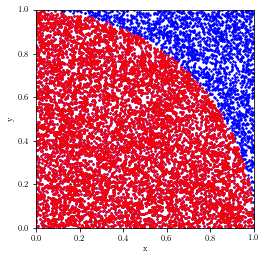

In [3]:
print "fractional integration error for pi:"
for M in [10, 100, 1000, 10000]:
    x = stats.uniform(0, 1).rvs(M)
    y = stats.uniform(0, 1).rvs(M)
    r2 = x*x+y*y
    print 'M: ', M, np.abs((np.pi-4.0*np.size(x[r2<1])/M)/np.pi)

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
plt.plot(x, y, '.k', markersize=3, c='blue')
plt.plot(x[r2<1], y[r2<1], '.k', markersize=3, c='red')
ax.axis([0, 1, 0, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')
plt.show() 

##  Markov Chains

A number of methods exist that are much more efficient than generic Monte Carlo integration. 
The most popular group of techniques is known as Markov chain Monte Carlo (MCMC) methods. 

MCMC returns a sample of points, or **chain**, from the k-dimensional parameter space, with 
a distribution that is **asymptotically proportional** to $p(\theta)$. The constant of 
proportionality is not important in the first class of problems listed above. In model 
comparison problems, the proportionality constant must be known and we will return to this 
point later.

Given such a chain of length M, the integral can be estimated as
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{M} \sum_{j=1}^M g(\theta_j).$$

Again, here the values of $\theta$ are **not** sampled **uniformly** from the volume;
they are sampled **proportionally** to $p(\theta)$! Note that there is no $p(\theta_j)$ 
term next to $g(\theta_j)$ because the proper weighting in the sum is taken care of 
by the sample itself! 

** How do we get such a chain? **

### What is a Markov Chain?

A Markov Chain is defined as a sequence of random variables where a parameter depends 
*only* on the preceding value.  Such processes are "memoryless".  
 
Mathematically, we have
$$p(\theta_{i+1}|\{\theta_i\}) = p(\theta_{i+1}|\,\theta_i).$$


In our context, $\theta$ can be thought of as a vector in multidimensional space, and a
realization of the chain represents a path through this space. To reach an equilibrium, or
stationary, distribution of positions, it is necessary that the transition probability is symmetric:
$$    p(\theta_{i+1}|\,\theta_i) = p(\theta_i |\, \theta_{i+1}). $$
This condition is called the detailed balance or reversibility condition. It
shows that the
probability of a jump between two points does not depend on the direction of the jump.

There are various algorithms for producing Markov chains that reach some prescribed
equilibrium distribution, $p(\theta)$. The use of resulting chains to perform Monte Carlo
integration is called *Markov chain Monte Carlo* (MCMC).


 


### What is a Markov Chain?

Let's see an example from
[Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

<img src="figures/Andrieu1.tiff" alt="Drawing" style="width: 600px;"/>
<img src="figures/Andrieu2.tiff" alt="Drawing" style="width: 600px;"/>
<img src="figures/Andrieu3.tiff" alt="Drawing" style="width: 600px;"/>

In [4]:
def doTransit(T, xold, Niter):

    for i in range(0,Niter):
        xnew = np.dot(xold, T)
        xold = xnew
  
    print 'Niter, x =', Niter, xold
    return xold

T = [[0, 1, 0], [0, 0.1, 0.9], [0.6, 0.4, 0]]

x1 = [0.5, 0.2, 0.3]
x2 = doTransit(T, x1, 1)
x3 = doTransit(T, x2, 1)
x100 = doTransit(T, x2, 97)


Niter, x = 1 [ 0.18  0.64  0.18]
Niter, x = 1 [ 0.108  0.316  0.576]
Niter, x = 97 [ 0.22131148  0.40983607  0.36885246]


In [5]:
x1 = [0.9, 0.1, 0.0]
x2 = doTransit(T, x1, 1)
x3 = doTransit(T, x2, 1)
x4 = doTransit(T, x3, 1)
x100 = doTransit(T, x4, 97)


Niter, x = 1 [ 0.    0.91  0.09]
Niter, x = 1 [ 0.054  0.127  0.819]
Niter, x = 1 [ 0.4914  0.3943  0.1143]
Niter, x = 97 [ 0.22131148  0.40983607  0.36885246]


In [6]:
x1 = [1.0, 0.0, 0.0]
x2 = doTransit(T, x1, 1)
x3 = doTransit(T, x2, 1)
x4 = doTransit(T, x3, 1)
x100 = doTransit(T, x4, 97)


Niter, x = 1 [ 0.  1.  0.]
Niter, x = 1 [ 0.   0.1  0.9]
Niter, x = 1 [ 0.54  0.37  0.09]
Niter, x = 97 [ 0.22131148  0.40983607  0.36885246]


In [7]:
x1 = [0.0, 0.0, 1.0]
x2 = doTransit(T, x1, 1)
x3 = doTransit(T, x2, 1)
x4 = doTransit(T, x3, 1)
x100 = doTransit(T, x4, 97)


Niter, x = 1 [ 0.6  0.4  0. ]
Niter, x = 1 [ 0.    0.64  0.36]
Niter, x = 1 [ 0.216  0.208  0.576]
Niter, x = 97 [ 0.22131148  0.40983607  0.36885246]


##  Markov Chain Monte Carlo

The modern version of the Markov Chain Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects at the Los Alamos National Laboratory. The name Monte Carlo
was given to the method by Nick Metropolis, who then invented the Metropolis sampler, which evolved into
one of the most famous MCMC algorithms, the Metropolis-Hastings algorithm. 

Algorithms for generating Markov chains are numerous and greatly vary in complexity
and applicability. Many of the most important ideas were generated in physics, especially
in the context of statistical mechanics, thermodynamics, and quantum field theory.

In order for a Markov chain to reach a stationary distribution proportional to $p(\theta)$,
the probability of arriving at a point $\theta_{i+1}$ must be proportional to $p(\theta_{i+1})$,
$$ p(\theta_{i+1}) = \int  T(\theta_{i+1}|\theta_i)  \,   p(\theta_i) \,    d \theta_i, $$
where the transition probability $T(\theta_{i+1}|\theta_i)$ is called the jump kernel or
transition kernel (and it is assumed that we know how to compute $p(\theta_i)$).

This requirement will be satisfied when the transition probability satisfies the detailed
balance condition
$$ T(\theta_{i+1}|\theta_i)  \,  p(\theta_i) = T(\theta_i|\theta_{i+1})  \,  p(\theta_{i+1}). $$

*Various MCMC algorithms differ in their choice of transition kernel*

##  Markov Chain Monte Carlo

*Various MCMC algorithms differ in their choice of transition kernel*

**The Metropolis-Hastings algorithm** adopts the kernel
$$  T(\theta_{i+1}\,|\,\theta_i) =  p_{\rm acc}(\theta_i,\theta_{i+1}) \, K(\theta_{i+1}\,|\,\theta_i), $$
where the proposed density distribution $K(\theta_{i+1}\,|\,\theta_i,)$ is an *arbitrary* function.
The proposed point $\theta_{i+1}$ is randomly accepted with the acceptance probability
$$   p_{\rm acc}(\theta_i,\theta_{i+1}) = { K(\theta_i\,|\,\theta_{i+1}) \,  p(\theta_{i+1}) \over
                       K(\theta_{i+1}\,|\,\theta_i) \,  p(\theta_i) } $$
(when exceeding 1, the proposed point $\theta_{i+1}$ is always accepted). 

** When $\theta_{i+1}$ is rejected, $\theta_i$ is added to the chain instead. **

A Gaussian distribution centered on $\theta_i$ is often used for $K(\theta_{i+1}|\theta_i)$.

The original Metropolis algorithm is based on a symmetric proposal distribution,
$K(\theta_{i+1}|\theta_i) =  K(\theta_i|\theta_{i+1})$, which then cancels out from
the acceptance probability. **In this case, $\theta_{i+1}$ is always accepted if
$p(\theta_{i+1}) > p(\theta_i)$, and if not, then it is accepted with a probability
$p(\theta_{i+1})/p(\theta_i)$.**


This algorithm guarantees that the chain will reach an equilibrium, or stationary, distribution, and it will approximate a sample drawn from $p(\theta)$! 

 

##  Markov Chain Monte Carlo

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1) given $\theta_i$ and $K(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ 

2) compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.

3) draw a random number between 0 and 1 from a uniform distribution; if it smaller than
   $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$.
   
4) if $\theta_{i+1}$ is accepted added it to the chain, if not, add $\theta_{i}$ to the chain.

5) use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is
  an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for 
  $\theta$ can be computed from 
  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{M} \sum_{j=1}^M \theta_j.$$

where M is the number of elements in the chain (e.g. 
the expectation value for $\theta$ is simply the mean value of chain elements). 
 
Let's try it! 


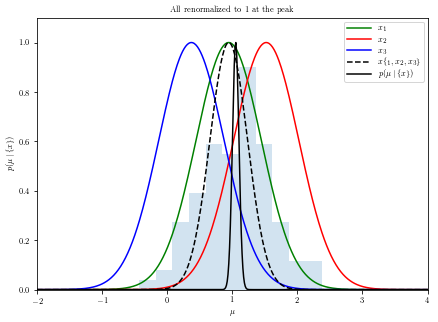

NOTE: Ndata= 100 sigmaData= 0.5 so sigma_mu= 0.05


In [8]:
np.random.seed(21)

def Likelihood(x,sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2/2/sigma**2))

def Prior(x):
    return 1.0/10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data)*Prior(x)

## generate data
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

# plot likelihood function 
muMin = mu - 6*sigma
muMax = mu + 6*sigma
muGrid = np.linspace(muMin, muMax, 500)
posterior = 0*muGrid

for j in range(0,np.size(muGrid)):
    posterior[j] = myPosterior(muGrid[j], sigma, data)

L1 = norm(data[1], sigma).pdf(muGrid) 
L2 = norm(data[2], sigma).pdf(muGrid) 
L3 = norm(data[3], sigma).pdf(muGrid) 
L1 = L1/np.max(L1)
L2 = L2/np.max(L2)
L3 = L3/np.max(L3)
L123 = L1 * L2 * L3
L123 = L123/np.max(L123)
posterior = posterior/np.max(posterior)
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$x_1$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$x_2$')
plt.plot(muGrid, L3, ls='-', c='blue', label=r'$x_3$')
plt.plot(muGrid, L123, ls='--', c='black', label=r'$x\{_1, x_2, x_3\}$')
plt.plot(muGrid, posterior, ls='-', c='black', label=r'$p(\mu\,|\,\{x\})$')

plt.hist(data, bins = 'auto', normed=1, histtype = 'stepfilled', alpha=0.2)

plt.xlim(muMin, muMax)
plt.ylim(0, 1.1)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(\mu\,|\,\{x\})$')
plt.title('All renormalized to 1 at the peak')
plt.legend()
plt.show() 

sigMu = sigma/np.sqrt(Ndata)
print 'NOTE: Ndata=', Ndata, 'sigmaData=', sigma, 'so sigma_mu=', sigMu

In [9]:
## illustrate Metropolis-Hastings algorithm 
muStart = 0.95
posteriorStart = myPosterior(muStart, sigma, data)
pRatio = posterior/posteriorStart

# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)
ax0 = fig.add_subplot(111)
ax0.axis([0.8, 1.3, 0, 1.1*np.max(pRatio)])
plt.xlabel('$\mu$')
plt.ylabel('p($\mu^{new}\,|\,$data,I)/($\mu=0.95\,|\,$data,I)')
plt.plot([0.8,1.0],[1.0,1.0], '-', c='cyan')
plt.plot([0.95,0.95],[0.0,2.0], '--', c='green', label=r'current $\mu_i$')

# plot proposal distribution
muG = np.linspace(0.0, 2.0,500)
prop = norm(muStart, sigmaProp).pdf(muG) 
plt.plot(muG, prop, c='red', label=r'Proposal K($\mu^\ast|\mu_{i}$)')
plt.plot(muGrid, pRatio, label=r'$p_{acc}=p(\mu^\ast)/p(\mu_i)$')
plt.plot(muGrid[pRatio<1], pRatio[pRatio<1], '.', c='black',label=r'prob. acceptance')
plt.plot(muGrid[pRatio>1], 1+0*muGrid[pRatio>1], '.', c='black')
ax0.legend(loc=2, prop=dict(size=14))
plt.show() 

print 'NOTE: we accept if a uniform random number (0-1) falls below the black curve.'

NameError: name 'sigmaProp' is not defined

In [ ]:
## generate a chain using Metropolis-Hastings algorithm 

# Markov chain 
M = 5000  # the requested number of steps in the chain
chain = np.linspace(0,1,M)
chain[0] = 0.5 # starting position
Pold = myPosterior(chain[0], sigma, data)

# gaussian width for "jumping" from the current position
#    sigmaProp            Na   Nr   Np     
# sigmaProp = 0.03    #  3992 1007 1968   (high acc, long burn-in) 
# sigmaProp = 0.3     #  1043 3956  534   (low acc, short burn-in) 
sigmaProp = 0.10      #  2514 2485 1248        

Na = Nr = Np = 0
# and now sample M times
for i in range(1,M):
    # 1) generate a new value: a gaussian jump from current value
    Cold = chain[i-1]
    Cnew = stats.norm(Cold, sigmaProp).rvs(1)
    Pnew = myPosterior(Cnew, sigma, data)
    # 2) acceptance condition 
    Pratio = Pnew / Pold  
    if (Pratio > 1): 
        Np += 1   # just a counter, nothing else is done 
    # if we only accept Pratio>1, we'll get a hill-climbing algorithm
    # instead, we'll randomly accept this proposal with probability Pratio 
    randNumber = stats.uniform(0, 1).rvs(1)
    if (randNumber < Pratio):
        # accepting this new proposed value
        chain[i] = Cnew
        Pold = Pnew
        Na += 1
    else:
        # rejecting the proposed value and stickin' with the previous one 
        chain[i] = Cold
        Nr += 1
 
print 'NNN(arp): ', Na, Nr, Np 

In [ ]:
# start plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

ax0 = fig.add_subplot(131)
muGrid = np.linspace(mu-sigma,mu+sigma,500)
posterior = 0*muGrid
for j in range(0,np.size(muGrid)):
    posterior[j] = myPosterior(muGrid[j], sigma, data)
plt.plot(muGrid, posterior)
ax0.axis([mu-sigma, mu+sigma, 0, 1.1*np.max(posterior)])
plt.xlabel('$\mu$')
plt.ylabel('p($\mu\,|\,$data,I)')

ax1 = fig.add_subplot(132)
x = np.linspace(1,M,M)
plt.plot(x, chain)
ax1.axis([0, M, np.min(chain), 1.1*np.max(chain)])
plt.xlabel('number')
plt.ylabel('chain')
# plot running mean: 
meanC = [np.mean(chain[:int(N)]) for N in x]
ax1.plot(x, meanC,c='red') 
ax1.plot(x, 0*x+np.mean(data),c='yellow') 

ax2 = fig.add_subplot(133)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chain[x>Nburn])
Nhist, bins, patches = plt.hist(chain[x>Nburn], bins = 'auto', histtype = 'stepfilled')
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(mu-sigma,mu+sigma,500)
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 
ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(mu-sigma, mu+sigma)
ax2.set_ylim(0, 1.2*np.max(gauss))

plt.show() 

##  Markov Chain Monte Carlo

*Various MCMC algorithms differ in their choice of transition kernel*

**The Metropolis-Hastings algorithm** adopts acceptance probability
$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = { p(\theta_{i+1}) \over p(\theta_i) }, $$
where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $K(\theta_{i+1}\,|\,\theta_i)$. A Gaussian distribution centered on 
$\theta_i$ is often used for $K(\theta_{i+1}|\theta_i)$.



## Caveats

Although $K(\theta_{i+1}|\theta_i)$ satisfies a Markov chain requirement that it
must be a function of only the current position $\theta_i$, it takes a number
of steps to reach a stationary distribution from an initial arbitrary position $\theta_0$.
**These early steps are called the "burn-in" and need to be discarded in analysis.**
There is no general theory for finding transition from the burn-in phase to
the stationary phase; several methods are used in practice. Gelman and Rubin
proposed to generate a number of chains and then compare the ratio of
the variance between the chains to the mean variance within the chains (this
ratio is known as the $R$ statistic). For stationary chains, this ratio will
be close to 1.  

When the posterior pdf is multimodal, the simple Metropolis--Hastings algorithm can
become stuck in a local mode and not find the globally best mode within a reasonable
running time. There are a number of better algorithms, such as Gibbs sampling, parallel
tempering, various genetic algorithms, and nested sampling.







<img src="figures/Andrieu4.tiff" alt="Drawing" style="width: 600px;"/>

##  Markov Chain Monte Carlo

For more involved examples, we will use two popular python modules:
PyMC and emcee. Quoting 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

** emcee **

*The emcee package (also known as MCMC Hammer, which is in the running for best Python package name in history) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

*Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

** PyMC **

*The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. My machine has a working fortran compiler, so pip install pymc worked without a problem (but from working with students, colleagues, and tutorial attendees, I can tell you that few scientists today have a system setup such that this will work out-of-the-box). For folks who don't have a fortran compiler installed, PyMC binaries for many systems can be quite easily installed with conda.*


More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/)


We will first use emcee to solve again the same problem we solved with 
homebrew MC, and then we will use pyMC to get 2-dimensional posterior pdf 
for location and scale parameters using a sample drawn from Cauchy distribution. 

In [ ]:
import emcee
np.random.seed(21)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

# emcee combines multiple "walkers", each of which is its own MCMC chain. 
# the number of trace results will be nwalkers * nsteps
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
Nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, Nburn:, :].reshape(-1, ndim).T

print("done")

In [ ]:
# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

chainE = emcee_trace[0]
M = np.size(chain)

ax1 = fig.add_subplot(131)
x = np.linspace(1,M,M)
plt.plot(x, chain)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chain)])
plt.xlabel('number')
plt.ylabel('chain')
# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in x]
ax1.plot(x, meanC,c='red') 
ax1.plot(x, 0*x+np.mean(data),c='yellow') 

ax2 = fig.add_subplot(132)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chainE[x>Nburn])
Nhist, bins, patches = plt.hist(chainE[x>Nburn], bins = 'auto', histtype = 'stepfilled')
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 
ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'{\bf Chain from emcee}')

ax2 = fig.add_subplot(133)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chain[x>Nburn])
Nhist, bins, patches = plt.hist(chain[x>Nburn], bins = 'auto', histtype = 'stepfilled')
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 
ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'{\bf Chain from homebrew}')


plt.show() 

##  Markov Chain Monte Carlo with PyMC

Now we will use pyMC to get a 2-dimensional posterior pdf 
for location and scale parameters using a sample drawn from 
Cauchy distribution, which we considered earlier using 
brute force grid search method: 


![Cauchy](figures/Lcauchy.tiff)

In [ ]:
### let's use pyMC instead of homebrew
## this is SIMPLIFIED code for the textbook figure 5.22, see
## http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html

# this fixes a problem when using older versions of pymc with newer
# versions of scipy
import scipy
scipy.derivative = scipy.misc.derivative
import pymc

#----------------------------------------------------------------------
# Draw the data sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

#----------------------------------------------------------------------
# Perform MCMC with pyMC:
def cauchy_logL(xi, sigma, mu):
    return ((xi.size-1)*np.log(sigma) - np.sum(np.log(sigma**2 + (xi-mu)** 2), 0))

# set up our Stochastic variables, mu and gamma
mu = pymc.Uniform('mu', -5, 5)
log_gamma = pymc.Uniform('log_gamma', -10, 10, value=0)

@pymc.deterministic
def gamma(log_gamma=log_gamma):
    return np.exp(log_gamma)

# set up our observed variable x
x = pymc.Cauchy('x', mu, gamma, observed=True, value=xi)

# set up our model dictionary
model = dict(mu=mu, log_gamma=log_gamma, gamma=gamma, x=x)

# perform the MCMC
S = pymc.MCMC(model)
S.sample(iter=50000, burn=5000)

# extract the traces we're interested in
trace_mu = S.trace('mu')[:]
trace_gamma = S.trace('gamma')[:]

# --- The End of MCMC block using pyMC ---  
#----------------------------------------------------------------------

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace_mu, trace_gamma,
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors


#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())
ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

In [ ]:
## this is code for the textbook figure 5.22, see
## http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html

# this fixes a problem when using older versions of pymc with newer
# versions of scipy
import scipy
scipy.derivative = scipy.misc.derivative
import pymc


def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

#----------------------------------------------------------------------
# Draw the data sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

#----------------------------------------------------------------------
# Perform MCMC with pyMC:

# set up our Stochastic variables, mu and gamma
mu = pymc.Uniform('mu', -5, 5)
log_gamma = pymc.Uniform('log_gamma', -10, 10, value=0)


@pymc.deterministic
def gamma(log_gamma=log_gamma):
    return np.exp(log_gamma)

# set up our observed variable x
x = pymc.Cauchy('x', mu, gamma, observed=True, value=xi)

# set up our model dictionary
model = dict(mu=mu, log_gamma=log_gamma, gamma=gamma, x=x)

# perform the MCMC
S = pymc.MCMC(model)
S.sample(iter=50000, burn=5000)

# extract the traces we're interested in
trace_mu = S.trace('mu')[:]
trace_gamma = S.trace('gamma')[:]
# --- The End of MCMC block using pyMC ---  
#----------------------------------------------------------------------

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace_mu, trace_gamma,
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

#----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace_mu, bins=mu_bins, normed=True)
hist_gamma, bins_gamma = np.histogram(trace_gamma, bins=gamma_bins,
                                      normed=True)


#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()